### Setup & Reproducibility

In [60]:
import numpy as np
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score, roc_auc_score

from tqdm import tqdm


In [61]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

In [62]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


### Data Loading & Preprocessing

In [63]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

In [64]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./../data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./../data",
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [65]:
num_train = len(train_dataset)
indices = np.random.permutation(num_train)

# Target model training set
target_train_size = int(0.5 * num_train)
target_train_indices = indices[:target_train_size]

# Non-member samples 
target_out_indices = indices[target_train_size:]
target_train_set = Subset(train_dataset, target_train_indices)
target_out_set = Subset(train_dataset, target_out_indices)


In [66]:
print(len(target_out_set))
print(len(target_train_set))

25000
25000


### Synthetic Data Generation for shadow models

In this section, we train a lightweight convolutional autoencoder on the target model’s training data in order to capture the global structure of CIFAR-10 images. New synthetic images are then generated by sampling in the latent space and decoding these samples into image space. This synthetic dataset is used to train the attacker’s shadow model, simulating a realistic adversary who does not have access to the original training data but only to an approximation of its distribution.

In [68]:
from models.autoencoder import SimpleConvAutoencoder
from utils.training import train_autoencoder

In [69]:
autoencoder = SimpleConvAutoencoder()
train_autoencoder(autoencoder, target_train_set)


In [70]:
import matplotlib.pyplot as plt

def show_images(images, n=8):
    images = images[:n]
    fig, axes = plt.subplots(1, n, figsize=(n*2, 2))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0)  
        ax.imshow(img)
        ax.axis("off")
    plt.show()

In [71]:
@torch.no_grad()
def encode_images(autoencoder, dataset, n_samples):
    autoencoder.eval()
    latents = []

    for i in range(n_samples):
        x, _ = dataset[i]
        x = x.unsqueeze(0)
        z = autoencoder.encoder(x)
        latents.append(z.squeeze(0))

    return torch.stack(latents)

In [72]:
N_LATENTS = len(target_train_set) 
latents = encode_images(autoencoder, target_train_set, N_LATENTS)


In [73]:
@torch.no_grad()
def generate_from_latents(autoencoder, latents, noise_std=0.1):
    autoencoder.eval()
    z_noisy = latents + noise_std * torch.randn_like(latents)
    images = autoencoder.decoder(z_noisy)
    return images

In [74]:
synthetic_images = generate_from_latents(
    autoencoder,
    latents,
    noise_std=0.1
)

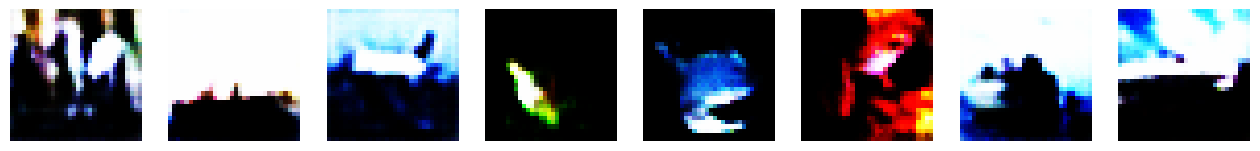

In [75]:
show_images(synthetic_images, n=8)

In [76]:
from data.synthetic_dataset import SyntheticCIFAR10Dataset

synthetic_dataset = SyntheticCIFAR10Dataset(synthetic_images)

Here we create a set for the shadow model using both real data and syntethic ones, in order to have an acceptable accuracy for the shadow model 

In [77]:
from torch.utils.data import ConcatDataset, Subset

# sizes
n_real = int(0.75 * len(target_out_set))
n_syn  = int(0.25 * len(target_out_set))

# subsets
real_idx = np.random.choice(len(target_out_set), n_real, replace=False)
syn_idx  = np.random.choice(len(synthetic_dataset), n_syn, replace=False)

real_subset = Subset(target_out_set, real_idx)
syn_subset  = Subset(synthetic_dataset, syn_idx)

# final dataset shadow 
shadow_dataset = ConcatDataset([real_subset, syn_subset])

In [78]:
indices = np.random.permutation(len(shadow_dataset))
split = len(indices) // 2

shadow_train_set = Subset(shadow_dataset, indices[:split])   # IN_shadow
shadow_test_set  = Subset(shadow_dataset, indices[split:])   # OUT_shadow

In [ ]:
print(len(shadow_test_set))
print(len(shadow_train_set)) 

12500
12500


### Target Model - Custom CNN Implementation

In [80]:
from models.target_cnn import CIFAR10CNN
from utils.training import train_classifier
import models.target_cnn

In [81]:
target_model = CIFAR10CNN()
train_classifier(
    target_model,
    target_train_set,
    epochs=20,
    device=DEVICE
)

Epoch 1/20 - Loss: 1.6399 - Acc: 40.77%
Epoch 2/20 - Loss: 1.2283 - Acc: 56.34%
Epoch 3/20 - Loss: 1.0113 - Acc: 64.60%
Epoch 4/20 - Loss: 0.8513 - Acc: 70.12%
Epoch 5/20 - Loss: 0.7292 - Acc: 74.42%
Epoch 6/20 - Loss: 0.6082 - Acc: 78.72%
Epoch 7/20 - Loss: 0.4878 - Acc: 82.67%
Epoch 8/20 - Loss: 0.3844 - Acc: 86.51%
Epoch 9/20 - Loss: 0.2849 - Acc: 89.94%
Epoch 10/20 - Loss: 0.1966 - Acc: 93.24%
Epoch 11/20 - Loss: 0.1484 - Acc: 94.89%
Epoch 12/20 - Loss: 0.1115 - Acc: 96.20%
Epoch 13/20 - Loss: 0.1032 - Acc: 96.40%
Epoch 14/20 - Loss: 0.0795 - Acc: 97.23%
Epoch 15/20 - Loss: 0.0713 - Acc: 97.55%
Epoch 16/20 - Loss: 0.0679 - Acc: 97.58%
Epoch 17/20 - Loss: 0.0614 - Acc: 97.96%
Epoch 18/20 - Loss: 0.0730 - Acc: 97.43%
Epoch 19/20 - Loss: 0.0482 - Acc: 98.32%
Epoch 20/20 - Loss: 0.0523 - Acc: 98.19%


In [82]:
from utils.training import evaluate_classifier

train_loss, train_acc = evaluate_classifier(
    target_model,
    target_train_set,
    device=DEVICE
)

test_loss, test_acc = evaluate_classifier(
    target_model,
    test_dataset,
    device=DEVICE
)

print(f"Train   - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
print(f"Test    - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")

Train   - Loss: 0.0489, Acc: 98.33%
Test    - Loss: 2.5572, Acc: 67.47%


### Confidence-Based Membership Inference Attack

In [83]:
from attacks.confidence_based import (
    max_posterior_scores,
    sweep_thresholds,
    plot_score_distributions,
    plot_precision_recall_vs_threshold,
    plot_roc_and_auc
)


In [84]:
in_scores  = max_posterior_scores(target_model, target_train_set, device=DEVICE)
out_scores = max_posterior_scores(target_model, target_out_set, device=DEVICE)

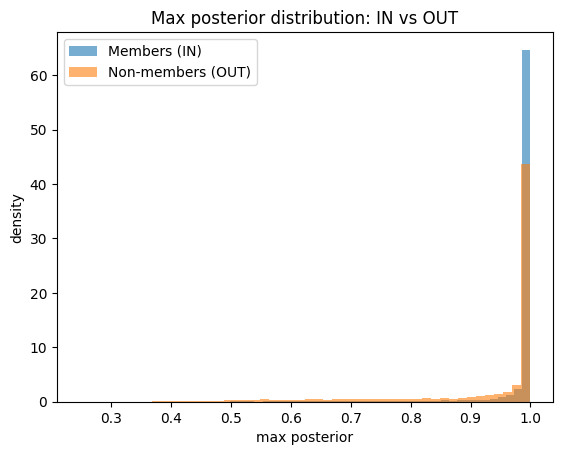

In [85]:
# Distribution plot 
plot_score_distributions(in_scores, out_scores)

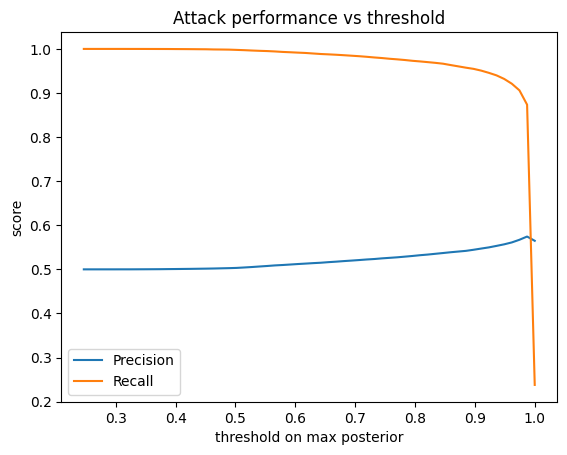

In [86]:
# Precision/Recall vs threshold 
thresholds, precisions, recalls = sweep_thresholds(in_scores, out_scores, n_thresholds=60)
plot_precision_recall_vs_threshold(thresholds, precisions, recalls)

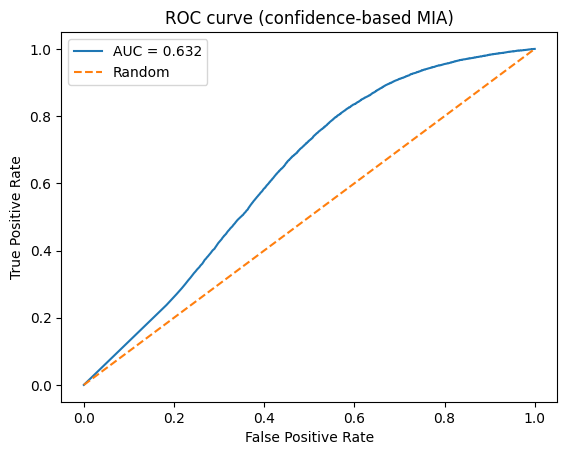

AUC: 0.6322112799999999


In [87]:
# ROC + AUC 
auc = plot_roc_and_auc(in_scores, out_scores)
print("AUC:", auc)

### Loss-Based Membership Inference Attack

In [88]:
from attacks.loss_based import (
    per_sample_ce_loss,
    sweep_thresholds2,
    plot_loss_distributions,
    plot_precision_recall_vs_threshold2,
    plot_roc_and_auc2
)


In [89]:
in_losses = per_sample_ce_loss(target_model, target_train_set, device=DEVICE)
out_losses = per_sample_ce_loss(target_model, target_out_set, device=DEVICE)

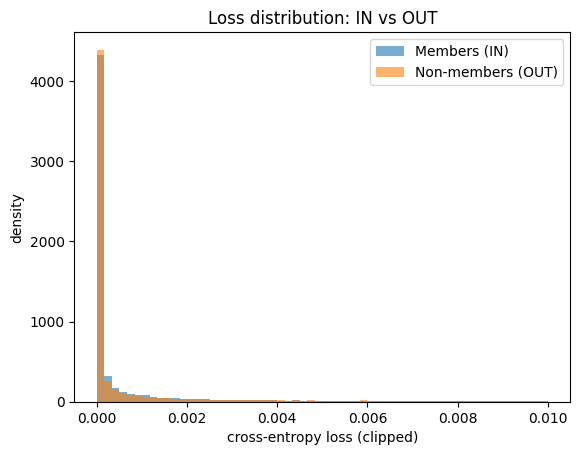

In [90]:
plot_loss_distributions(in_losses, out_losses)

In [91]:
np.quantile(in_losses,  [0.5, 0.9, 0.99])

array([2.44376060e-05, 2.33507302e-02, 1.37969701e+00])

In [92]:
np.quantile(out_losses, [0.5, 0.9, 0.99])

array([5.61606442e-03, 9.33827724e+00, 2.23189151e+01])

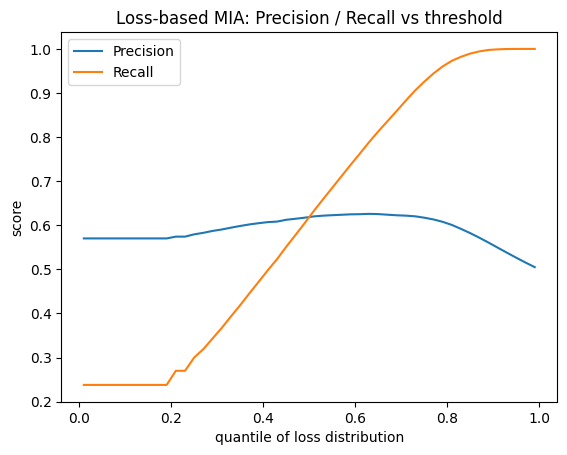

In [93]:
thresholds, precisions, recalls = sweep_thresholds2(in_losses, out_losses)
plot_precision_recall_vs_threshold2(thresholds, precisions, recalls)

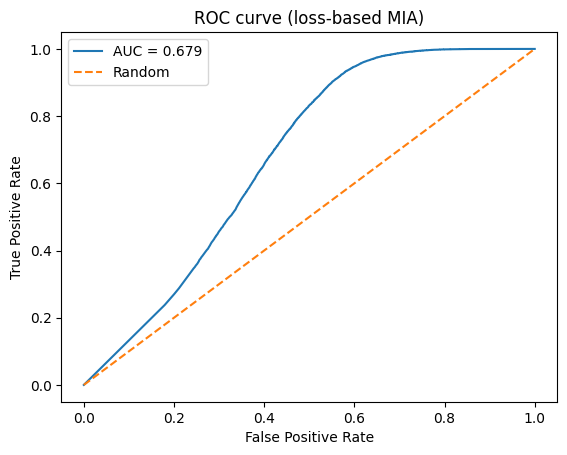

AUC: 0.6790667088


In [94]:
auc = plot_roc_and_auc2(in_losses, out_losses)
print("AUC:", auc)

### Shadow Models Training

In [95]:
from models.shadow_cnn import ShadowCNN
from utils.training import train_classifier

In [96]:
shadow_model = ShadowCNN().to(DEVICE)

train_classifier(
    model=shadow_model,
    dataset=shadow_train_set,
    epochs=30,
    batch_size=128,
    lr=1e-3,
    device=DEVICE
)

Epoch 1/30 - Loss: 2.0214 - Acc: 25.31%
Epoch 2/30 - Loss: 1.7493 - Acc: 36.55%
Epoch 3/30 - Loss: 1.6255 - Acc: 41.23%
Epoch 4/30 - Loss: 1.5447 - Acc: 44.31%
Epoch 5/30 - Loss: 1.4698 - Acc: 46.88%
Epoch 6/30 - Loss: 1.4086 - Acc: 49.32%
Epoch 7/30 - Loss: 1.3560 - Acc: 50.93%
Epoch 8/30 - Loss: 1.2997 - Acc: 52.54%
Epoch 9/30 - Loss: 1.2600 - Acc: 54.30%
Epoch 10/30 - Loss: 1.2089 - Acc: 55.90%
Epoch 11/30 - Loss: 1.1763 - Acc: 56.96%
Epoch 12/30 - Loss: 1.1330 - Acc: 58.54%
Epoch 13/30 - Loss: 1.0983 - Acc: 60.07%
Epoch 14/30 - Loss: 1.0587 - Acc: 61.37%
Epoch 15/30 - Loss: 1.0248 - Acc: 62.50%
Epoch 16/30 - Loss: 0.9791 - Acc: 63.81%
Epoch 17/30 - Loss: 0.9574 - Acc: 64.93%
Epoch 18/30 - Loss: 0.9249 - Acc: 66.25%
Epoch 19/30 - Loss: 0.8810 - Acc: 67.46%
Epoch 20/30 - Loss: 0.8469 - Acc: 69.19%
Epoch 21/30 - Loss: 0.8216 - Acc: 69.77%
Epoch 22/30 - Loss: 0.8003 - Acc: 70.48%
Epoch 23/30 - Loss: 0.7756 - Acc: 71.83%
Epoch 24/30 - Loss: 0.7506 - Acc: 72.29%
Epoch 25/30 - Loss: 0.737

In [97]:
train_loss, train_acc = evaluate_classifier(
    shadow_model, shadow_train_set
)

test_loss, test_acc = evaluate_classifier(
    shadow_model, shadow_test_set
)

print(f"Shadow IN  - Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
print(f"Shadow OUT - Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%")


Shadow IN  - Loss: 0.6386 | Acc: 76.62%
Shadow OUT - Loss: 2.3069 | Acc: 46.11%


### Attack model's dataset

In [98]:
from utils.attack_features import extract_attack_features

X_in  = extract_attack_features(shadow_model, shadow_train_set, DEVICE)
X_out = extract_attack_features(shadow_model, shadow_test_set, DEVICE)

y_in  = np.ones(len(X_in))
y_out = np.zeros(len(X_out))

X_attack = np.vstack([X_in, X_out])
y_attack = np.concatenate([y_in, y_out])


Here, we have to make sure that the dataset used to evaluate the attack model is a mix of elements in the target_train_set and the target_out_set to see if the attack model behaves correctly

In [99]:
from torch.utils.data import Subset

n_test = 2000  

# IN elements (members of target)
idx_in = np.random.choice(len(target_train_set), n_test, replace=False)
attack_test_in = Subset(target_train_set, idx_in)

# OUT elements (non-members of target)
idx_out = np.random.choice(len(target_out_set), n_test, replace=False)
attack_test_out = Subset(target_out_set, idx_out)



In [100]:
X_test_in = extract_attack_features(target_model, attack_test_in, DEVICE)
X_test_out = extract_attack_features(target_model, attack_test_out, DEVICE)

X_attack_test = np.vstack([X_test_in, X_test_out])
y_attack_test = np.concatenate([
    np.ones(len(X_test_in)),   # members
    np.zeros(len(X_test_out))  # non-members
])

In [102]:
print(X_in.mean(), X_out.mean())
print(X_in.std(),  X_out.std())

0.1 0.1
0.24558462 0.22829166


### Shadow-Based Attack Model

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from models.attack_model import AttackMLP

X_tensor = torch.tensor(X_attack, dtype=torch.float32)
y_tensor = torch.tensor(y_attack, dtype=torch.float32).unsqueeze(1)

attack_dataset = TensorDataset(X_tensor, y_tensor)
attack_loader = DataLoader(attack_dataset, batch_size=128, shuffle=True)

attack_model = AttackMLP(input_dim=X_attack.shape[1]).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(attack_model.parameters(), lr=1e-3)

attack_model.train()
epochs = 150
for ep in range(epochs):
    total_loss = 0.0
    for xb, yb in attack_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = attack_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {ep+1}/{epochs} - Attack Loss: {total_loss/len(attack_loader):.4f}")


Epoch 1/150 - Attack Loss: 0.6919
Epoch 2/150 - Attack Loss: 0.6878
Epoch 3/150 - Attack Loss: 0.6842
Epoch 4/150 - Attack Loss: 0.6816
Epoch 5/150 - Attack Loss: 0.6793
Epoch 6/150 - Attack Loss: 0.6771
Epoch 7/150 - Attack Loss: 0.6750
Epoch 8/150 - Attack Loss: 0.6730
Epoch 9/150 - Attack Loss: 0.6703
Epoch 10/150 - Attack Loss: 0.6681
Epoch 11/150 - Attack Loss: 0.6660
Epoch 12/150 - Attack Loss: 0.6637
Epoch 13/150 - Attack Loss: 0.6614
Epoch 14/150 - Attack Loss: 0.6596
Epoch 15/150 - Attack Loss: 0.6573
Epoch 16/150 - Attack Loss: 0.6557
Epoch 17/150 - Attack Loss: 0.6540
Epoch 18/150 - Attack Loss: 0.6524
Epoch 19/150 - Attack Loss: 0.6512
Epoch 20/150 - Attack Loss: 0.6499
Epoch 21/150 - Attack Loss: 0.6488
Epoch 22/150 - Attack Loss: 0.6477
Epoch 23/150 - Attack Loss: 0.6469
Epoch 24/150 - Attack Loss: 0.6461
Epoch 25/150 - Attack Loss: 0.6453
Epoch 26/150 - Attack Loss: 0.6449
Epoch 27/150 - Attack Loss: 0.6440
Epoch 28/150 - Attack Loss: 0.6435
Epoch 29/150 - Attack Loss: 0

In [103]:
attack_model.eval()
with torch.no_grad():
    logits = attack_model(
        torch.tensor(X_attack_test, dtype=torch.float32).to(DEVICE)
    )
    probs = torch.sigmoid(logits).cpu().numpy().ravel()

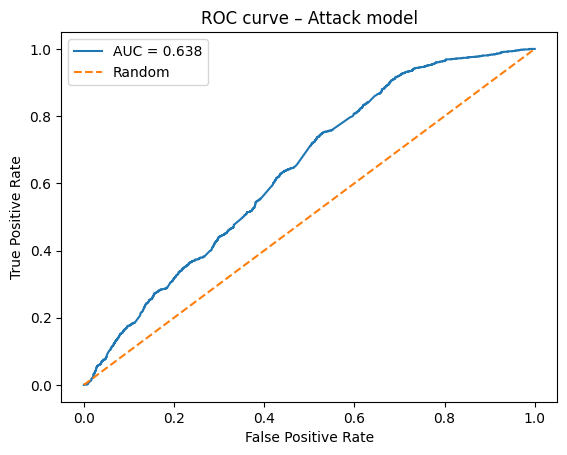

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_attack_test, probs)
auc = roc_auc_score(y_attack_test, probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve – Attack model")
plt.legend()
plt.show()

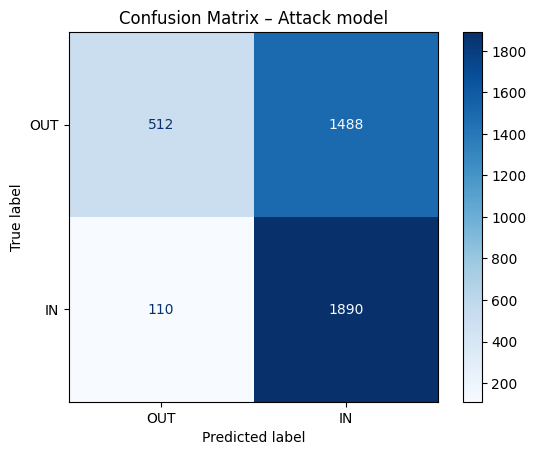

In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (probs > 0.5).astype(int)

cm = confusion_matrix(y_attack_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["OUT", "IN"]
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Attack model")
plt.show()

### Noised real-data approach

In this section, instead of using real data combined with synthetic one, we're going to use noised real-data to train our shadow models

In [106]:
from utils.noise import NoisyRealDataset
from torch.utils.data import Subset

In [107]:
noisy_real_pool = NoisyRealDataset(target_out_set, noise_std=0.1)

idx = np.random.permutation(len(noisy_real_pool))
split = len(idx) // 2

shadow_train_set_noisy = Subset(noisy_real_pool, idx[:split])
shadow_test_set_noisy  = Subset(noisy_real_pool, idx[split:])

In [108]:
shadow_model_noisy = ShadowCNN().to(DEVICE)

train_classifier(
    model=shadow_model_noisy,
    dataset=shadow_train_set_noisy,
    epochs=30,
    batch_size=128,
    lr=1e-3,
    device=DEVICE
)

Epoch 1/30 - Loss: 1.9450 - Acc: 30.56%
Epoch 2/30 - Loss: 1.5637 - Acc: 44.06%
Epoch 3/30 - Loss: 1.4177 - Acc: 49.74%
Epoch 4/30 - Loss: 1.3322 - Acc: 52.24%
Epoch 5/30 - Loss: 1.2596 - Acc: 55.39%
Epoch 6/30 - Loss: 1.2072 - Acc: 57.55%
Epoch 7/30 - Loss: 1.1693 - Acc: 58.42%
Epoch 8/30 - Loss: 1.1076 - Acc: 60.74%
Epoch 9/30 - Loss: 1.0614 - Acc: 62.77%
Epoch 10/30 - Loss: 1.0270 - Acc: 64.00%
Epoch 11/30 - Loss: 0.9862 - Acc: 65.33%
Epoch 12/30 - Loss: 0.9498 - Acc: 66.66%
Epoch 13/30 - Loss: 0.9039 - Acc: 68.67%
Epoch 14/30 - Loss: 0.8783 - Acc: 69.05%
Epoch 15/30 - Loss: 0.8384 - Acc: 70.58%
Epoch 16/30 - Loss: 0.8004 - Acc: 71.91%
Epoch 17/30 - Loss: 0.7791 - Acc: 72.54%
Epoch 18/30 - Loss: 0.7439 - Acc: 74.07%
Epoch 19/30 - Loss: 0.7113 - Acc: 75.34%
Epoch 20/30 - Loss: 0.6724 - Acc: 76.42%
Epoch 21/30 - Loss: 0.6627 - Acc: 76.62%
Epoch 22/30 - Loss: 0.6246 - Acc: 78.06%
Epoch 23/30 - Loss: 0.6148 - Acc: 78.15%
Epoch 24/30 - Loss: 0.5934 - Acc: 79.03%
Epoch 25/30 - Loss: 0.570

In [39]:
train_loss, train_acc = evaluate_classifier(
    shadow_model_noisy, shadow_train_set_noisy
)

test_loss, test_acc = evaluate_classifier(
    shadow_model_noisy, shadow_test_set_noisy
)

print(f"Shadow IN  - Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
print(f"Shadow OUT - Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%")

Shadow IN  - Loss: 0.5454 | Acc: 80.73%
Shadow OUT - Loss: 1.4818 | Acc: 56.36%


In [40]:
from utils.attack_features import extract_attack_features

X_in_noisy  = extract_attack_features(shadow_model_noisy, shadow_train_set_noisy, DEVICE)
X_out_noisy = extract_attack_features(shadow_model_noisy, shadow_test_set_noisy, DEVICE)

y_in_noisy  = np.ones(len(X_in_noisy))
y_out_noisy = np.zeros(len(X_out_noisy))

X_attack_noisy = np.vstack([X_in_noisy, X_out_noisy])
y_attack_noisy = np.concatenate([y_in_noisy, y_out_noisy])


In [43]:
from torch.utils.data import DataLoader, TensorDataset

attack_model_noisy = AttackMLP(input_dim=X_attack_noisy.shape[1]).to(DEVICE)

X_t = torch.tensor(X_attack_noisy, dtype=torch.float32)
y_t = torch.tensor(y_attack_noisy, dtype=torch.float32).unsqueeze(1)

loader = DataLoader(TensorDataset(X_t, y_t), batch_size=128, shuffle=True)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(attack_model_noisy.parameters(), lr=1e-3)

attack_model_noisy.train()
for ep in range(150):
    total = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(attack_model_noisy(xb), yb)
        loss.backward()
        optimizer.step()
        total += loss.item()
    print(f"[Noised] Epoch {ep+1}/150 - Loss: {total/len(loader):.4f}")


[Noised] Epoch 1/150 - Loss: 0.6928
[Noised] Epoch 2/150 - Loss: 0.6916
[Noised] Epoch 3/150 - Loss: 0.6907
[Noised] Epoch 4/150 - Loss: 0.6899
[Noised] Epoch 5/150 - Loss: 0.6892
[Noised] Epoch 6/150 - Loss: 0.6888
[Noised] Epoch 7/150 - Loss: 0.6886
[Noised] Epoch 8/150 - Loss: 0.6882
[Noised] Epoch 9/150 - Loss: 0.6881
[Noised] Epoch 10/150 - Loss: 0.6879
[Noised] Epoch 11/150 - Loss: 0.6877
[Noised] Epoch 12/150 - Loss: 0.6878
[Noised] Epoch 13/150 - Loss: 0.6877
[Noised] Epoch 14/150 - Loss: 0.6876
[Noised] Epoch 15/150 - Loss: 0.6876
[Noised] Epoch 16/150 - Loss: 0.6874
[Noised] Epoch 17/150 - Loss: 0.6873
[Noised] Epoch 18/150 - Loss: 0.6874
[Noised] Epoch 19/150 - Loss: 0.6873
[Noised] Epoch 20/150 - Loss: 0.6872
[Noised] Epoch 21/150 - Loss: 0.6872
[Noised] Epoch 22/150 - Loss: 0.6873
[Noised] Epoch 23/150 - Loss: 0.6871
[Noised] Epoch 24/150 - Loss: 0.6873
[Noised] Epoch 25/150 - Loss: 0.6872
[Noised] Epoch 26/150 - Loss: 0.6872
[Noised] Epoch 27/150 - Loss: 0.6872
[Noised] E

In [47]:
attack_model_noisy.eval()
with torch.no_grad():
    logits2 = attack_model_noisy(
        torch.tensor(X_attack_test, dtype=torch.float32).to(DEVICE)
    )
    probs2 = torch.sigmoid(logits2).cpu().numpy().ravel()

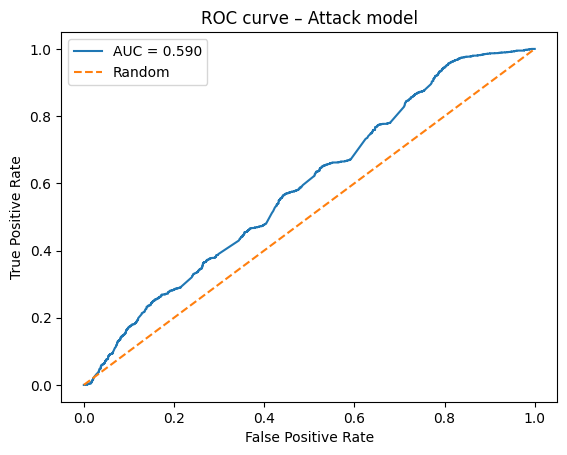

In [48]:
fpr2, tpr2, _ = roc_curve(y_attack_test, probs2)
auc2 = roc_auc_score(y_attack_test, probs2)

plt.figure()
plt.plot(fpr2, tpr2, label=f"AUC = {auc2:.3f}")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve – Attack model")
plt.legend()
plt.show()

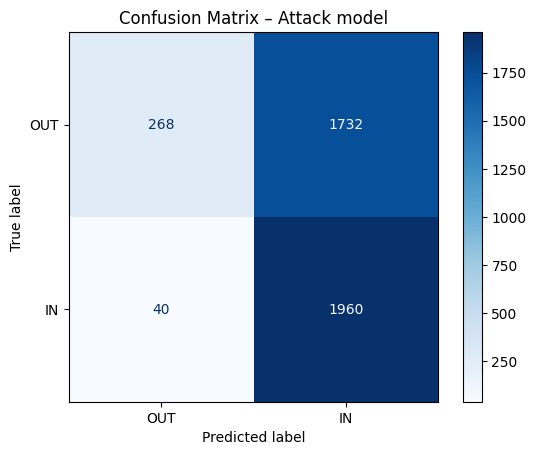

In [51]:
y_pred2 = (probs2 > 0.5).astype(int)

cm2 = confusion_matrix(y_attack_test, y_pred2)

disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm2,
    display_labels=["OUT", "IN"]
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Attack model")
plt.show()

In [54]:
from sklearn.metrics import accuracy_score

acc_noisy = accuracy_score(y_attack_test, y_pred2)
acc_synth = accuracy_score(y_attack_test, y_pred)
print("Attack accuracy (Noised):", acc_noisy)
print("Attack accuracy (With synthetic data):", acc_synth)

Attack accuracy (Noised): 0.557
Attack accuracy (With synthetic data): 0.6005
